In [1]:
import copy

import numpy as np
import scipy
import pyart

import phase

from matplotlib import pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
test_ffn = '/g/data/hj10/admin/cp2/level_1b_sband_sur/v2020/ppi/2014/20141127/cp2-s_20141127_063502.sur.cfradial.nc'

In [3]:
radar = pyart.io.read(test_ffn)

In [4]:
# GateFilter
gatefilter = phase.do_gatefilter(radar,
                                     refl_name='reflectivity',
                                     phidp_name="differential_phase",
                                     rhohv_name='corrected_cross_correlation_ratio',
                                     zdr_name="corrected_differential_reflectivity",
                                     snr_name='signal_to_noise_ratio')

#generate 8bit phidp and 16bit phidp
phidp_8bit, kdp_8bit = phase.phidp_giangrande_8bit(radar, gatefilter, refl_field='reflectivity', ncp_field='normalized_coherent_power',
                     rhv_field='corrected_cross_correlation_ratio', phidp_field='differential_phase')
    
#insert back into radar object
radar.add_field('corrected_differential_phase_8bit', phidp_8bit, replace_existing=True)
radar.add_field('corrected_specific_differential_phase_8bit', kdp_8bit, replace_existing=True)

/home/548/jss548/dev/projects/PST/polarimetric_rain/phase.py:63: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(num / xa_valid_count)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.8/site-packages/pyart/filters/gatefilter.py:617: RuntimeWarning: invalid value encountered in greater
  marked = self._get_fdata(field) > value
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.8/site-packages/pyart/correct/phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.8/site-packages/pyart/correct/phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise


In [5]:
#create difference map
kdp_16 = radar.fields['corrected_specific_differential_phase']['data'][:].copy()
kdp_8 = radar.fields['corrected_specific_differential_phase_8bit']['data'][:].copy()
kdp_diff = kdp_16-kdp_8
radar.add_field_like('corrected_specific_differential_phase', 'corrected_specific_differential_phase_error', kdp_diff, replace_existing=True)

phidp_16 = radar.fields['corrected_differential_phase']['data'][:].copy()
phidp_8 = radar.fields['corrected_differential_phase_8bit']['data'][:].copy()
phidp_diff = phidp_16-phidp_8
radar.add_field_like('corrected_differential_phase', 'corrected_differential_phase_error', phidp_diff, replace_existing=True)

Text(0.5, 1.0, '8bit for sweep 6')

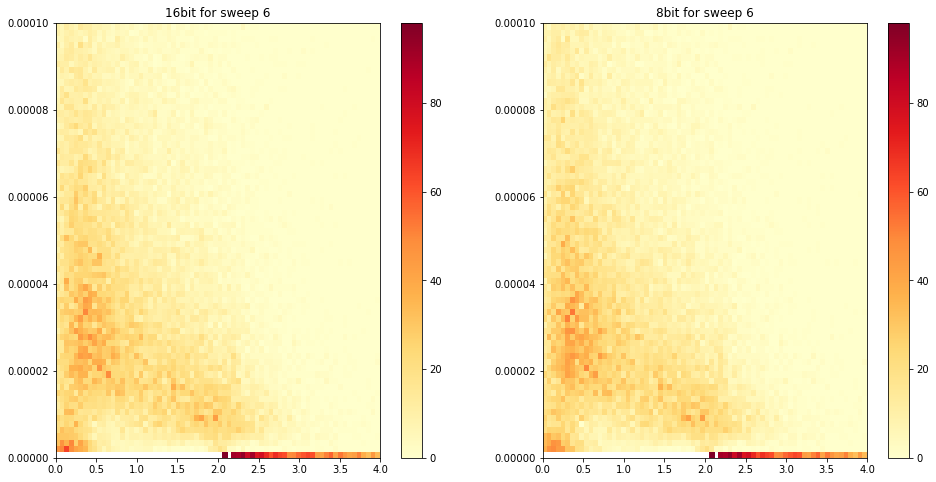

In [37]:
# plot the difference as an xy plot 
tilt = 6

refl_sweep = radar.get_field(tilt, 'reflectivity')
zdr_sweep = radar.get_field(tilt, 'corrected_differential_reflectivity')
kdp_16_sweep = radar.get_field(tilt, 'corrected_specific_differential_phase')
kdp_8_sweep = radar.get_field(tilt, 'corrected_specific_differential_phase_8bit')      
phidp_16_sweep = radar.get_field(tilt, 'corrected_differential_phase')
phidp_8_sweep = radar.get_field(tilt, 'corrected_differential_phase_8bit')      

# phidp_diff_sweep = phidp_16_sweep-phidp_8_sweep
# kdp_diff = kdp_16_sweep-kdp_8_sweep

selfc_16bit = kdp_16_sweep / (10**((refl_sweep) / 10.))
selfc_8bit = kdp_8_sweep / (10**((refl_sweep) / 10.))


# fig = plt.figure(figsize=(16, 8))
# plt.plot(phidp_diff.flatten(), 'b.', ms=1)
# plt.title('16bit - 8bit phidp difference for sweep ' + str(tilt))

# fig = plt.figure(figsize=(16, 8))
# plt.plot(kdp_diff.flatten(), 'r.', ms=1)
# plt.ylim([-0.5,0.5])
# plt.title('16bit-8bit kdp difference for sweep ' + str(tilt))

fig = plt.figure(figsize=(16, 8))
ax=plt.subplot(121)
h = plt.hist2d(zdr_sweep.flatten(), selfc_16bit.flatten(), range=((0, 4), (0, 1e-4)), bins=70, cmap="YlOrRd", cmax=100)
plt.colorbar(h[3], ax=ax)
plt.title('16bit for sweep ' + str(tilt))
ax=plt.subplot(122)
plt.hist2d(zdr_sweep.flatten(), selfc_8bit.flatten(), range=((0, 4), (0, 1e-4)), bins=70, cmap="YlOrRd", cmax=100)
plt.colorbar(h[3], ax=ax)
plt.title('8bit for sweep ' + str(tilt))

(-50.0, 50.0)

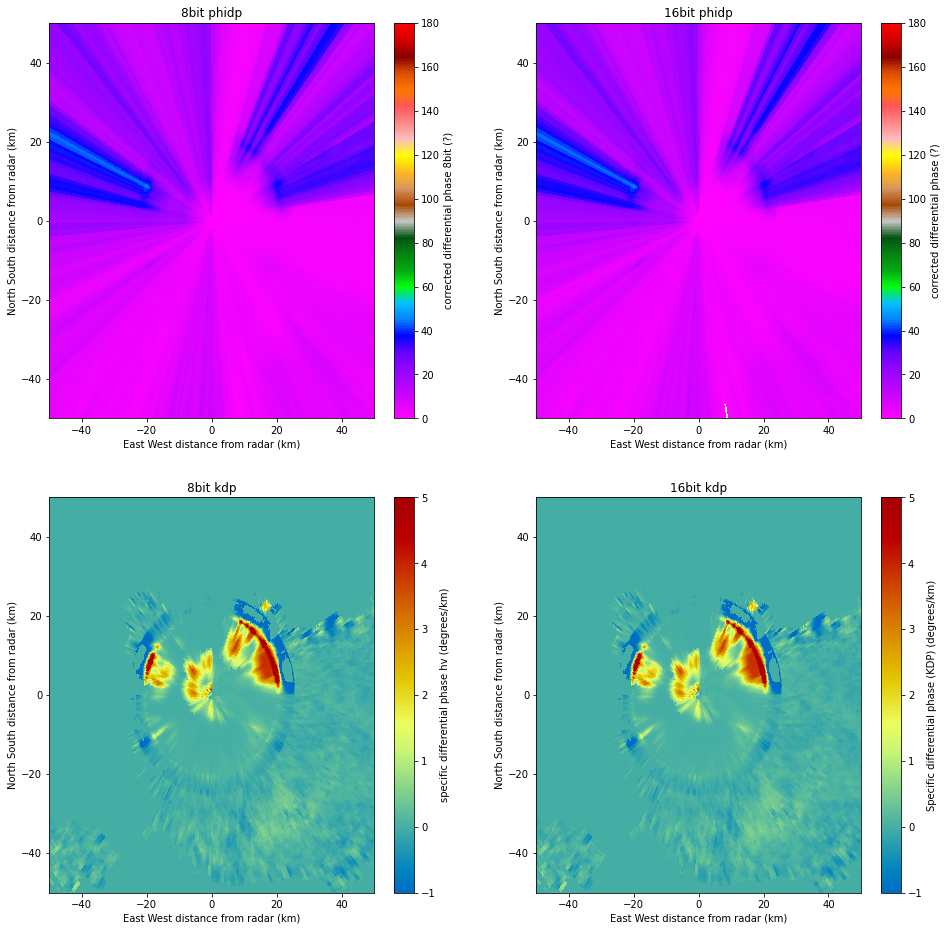

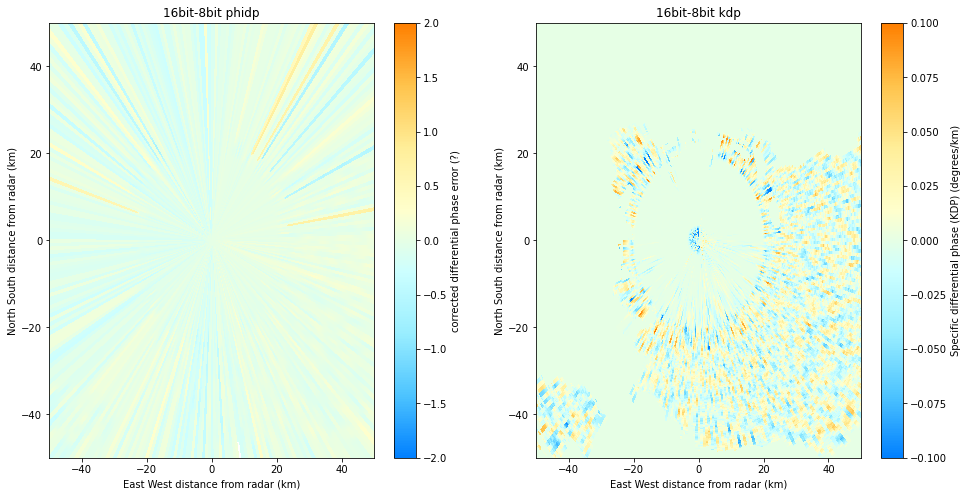

In [20]:
display = pyart.graph.RadarDisplay(radar)

tilt = 6
xlim = [-50,50]
ylim = [-50,50]
fig = plt.figure(figsize=(16, 16))
ax = plt.subplot(221)
display.plot_ppi('corrected_differential_phase_8bit',tilt, vmin=0, vmax=180, cmap='pyart_Wild25', title='8bit phidp')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax = plt.subplot(222)
display.plot_ppi('corrected_differential_phase',tilt, vmin=0, vmax=180, cmap='pyart_Wild25', title='16bit phidp')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax = plt.subplot(223)
display.plot_ppi('corrected_specific_differential_phase_8bit',tilt, vmin=-1, vmax=5, cmap='pyart_HomeyerRainbow', title='8bit kdp')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax = plt.subplot(224)
display.plot_ppi('corrected_specific_differential_phase',tilt, vmin=-1, vmax=5, cmap='pyart_HomeyerRainbow', title='16bit kdp')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
display.plot_ppi('corrected_differential_phase_error',tilt, vmin=-2, vmax=2, cmap='pyart_BuOr8', title='16bit-8bit phidp')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax = plt.subplot(122)
display.plot_ppi('corrected_specific_differential_phase_error',tilt, vmin=-0.1, vmax=0.1, cmap='pyart_BuOr8', title='16bit-8bit kdp')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

